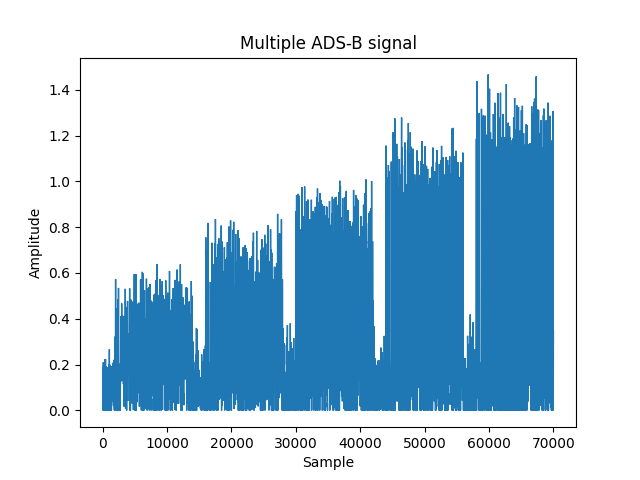

In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from Functions.signal_generator import generate_ADSB_multiple, \
                                        digitize_signal, get_signal_energy, normalize_signal, \
                                        get_last_generated_signal_length, generate_approx, t_prescaler
from Functions.crc import generate_adsb_crc
from preambules_list import preambule_list, Preambule
from Functions.preambule_variant import Correlation
from Functions.approximations_list import Approximation

data_bits = bytes([0x8D, 0x40, 0x6B, 0x90, 0x20, 0x15, 0xA6, 0x78, 0xD4, 0xD2, 0x20])

#Generate and append CRC
crc_bits = generate_adsb_crc(data_bits)
full_bits = data_bits + crc_bits

multiple_signal_gaps = 200
signal_amount = 5
multiple_amplitudes = np.linspace(0.3, 1, signal_amount)

full_multiple_signal = generate_ADSB_multiple(multiple_amplitudes, full_bits)
full_multiple_signal_digitized, digitized_t = digitize_signal(full_multiple_signal, 100E6, 10E6, 1.4, 2**10)
one_signal_length = int(get_last_generated_signal_length()/t_prescaler)

plt.figure()
plt.stairs(full_multiple_signal, baseline=None)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Multiple ADS-B signal')
plt.show()

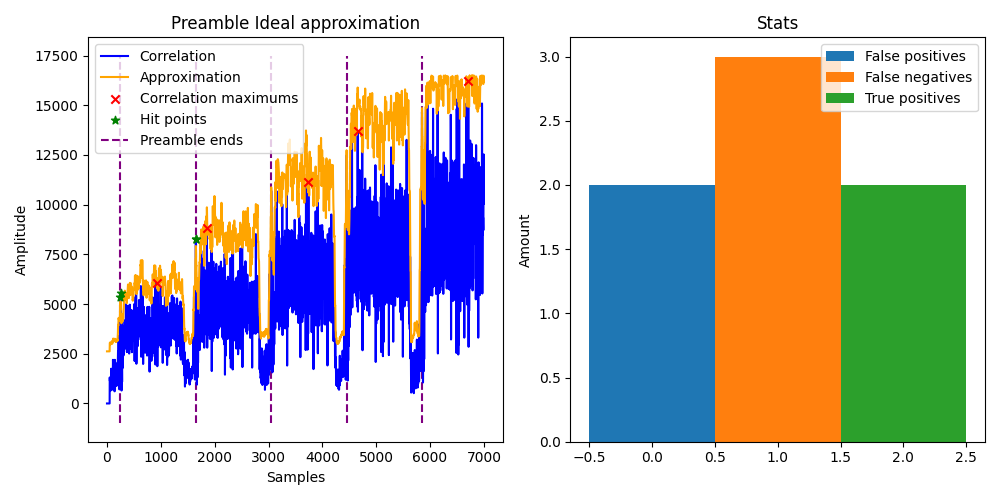

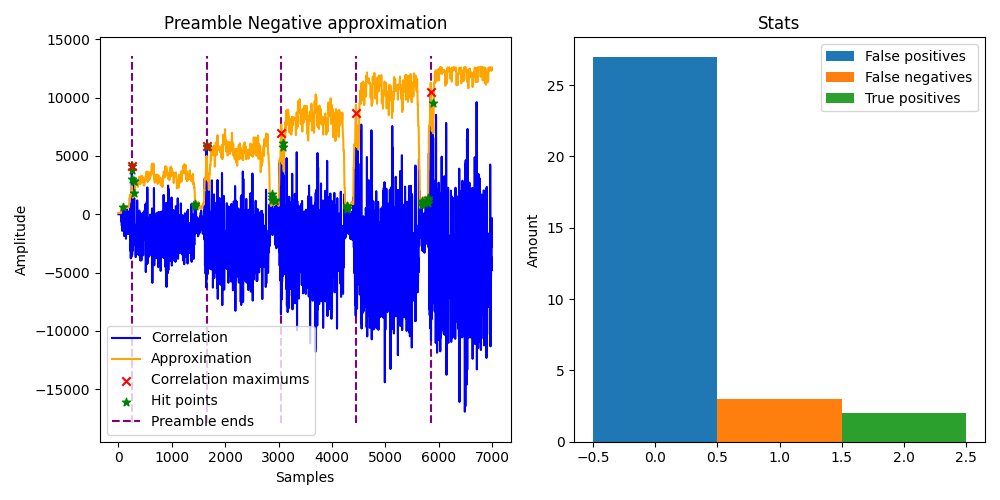

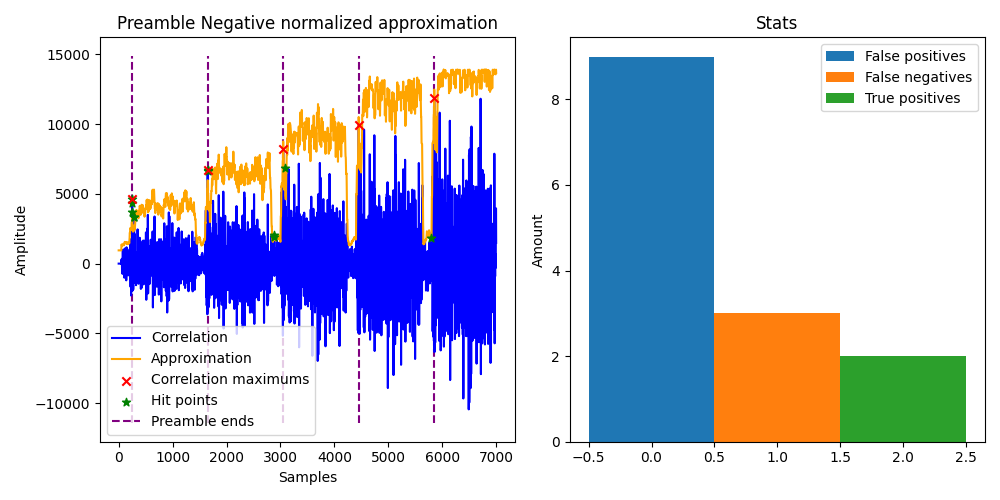

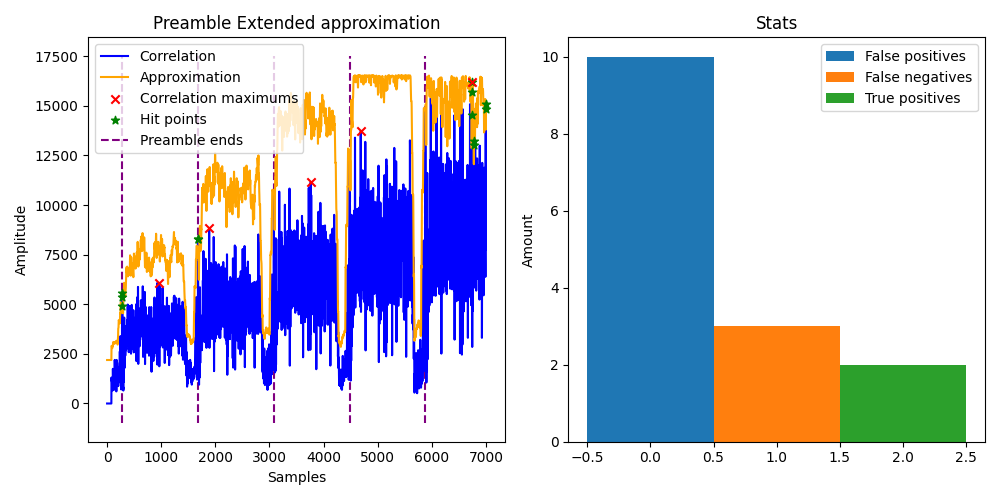

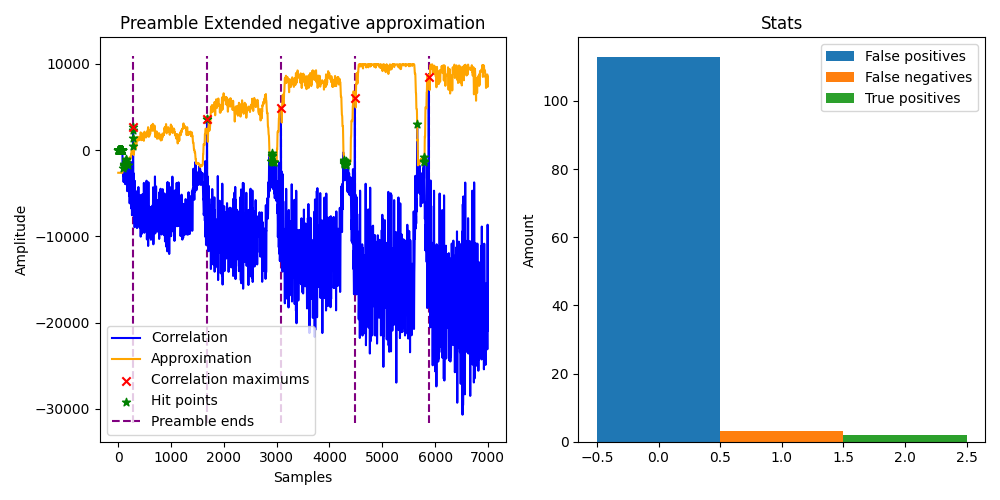

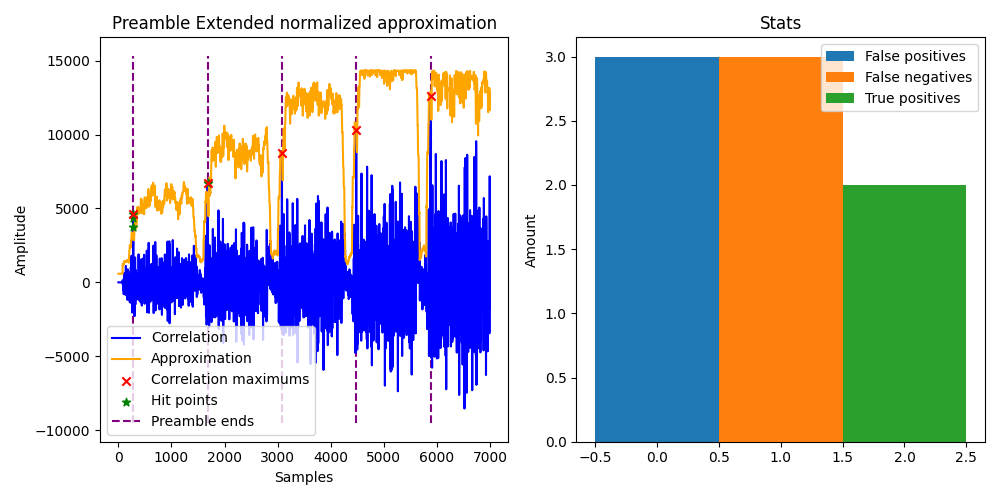

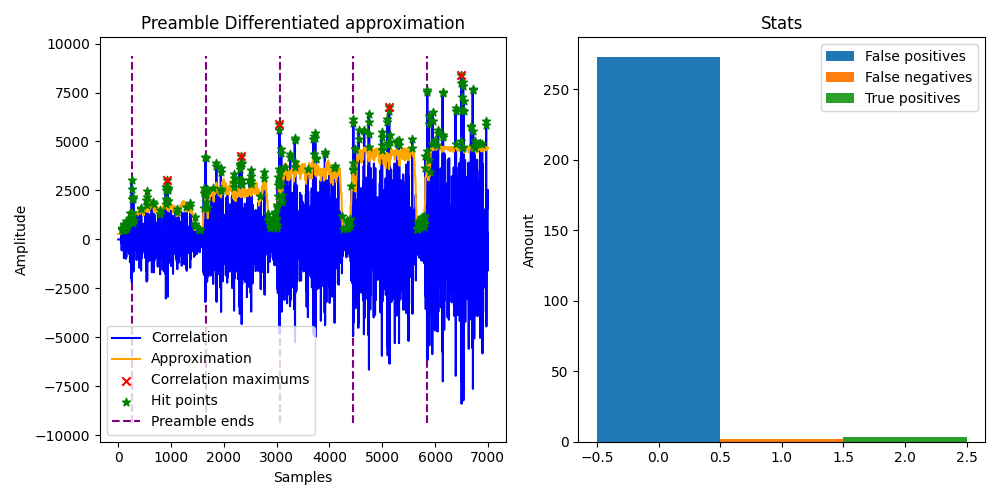

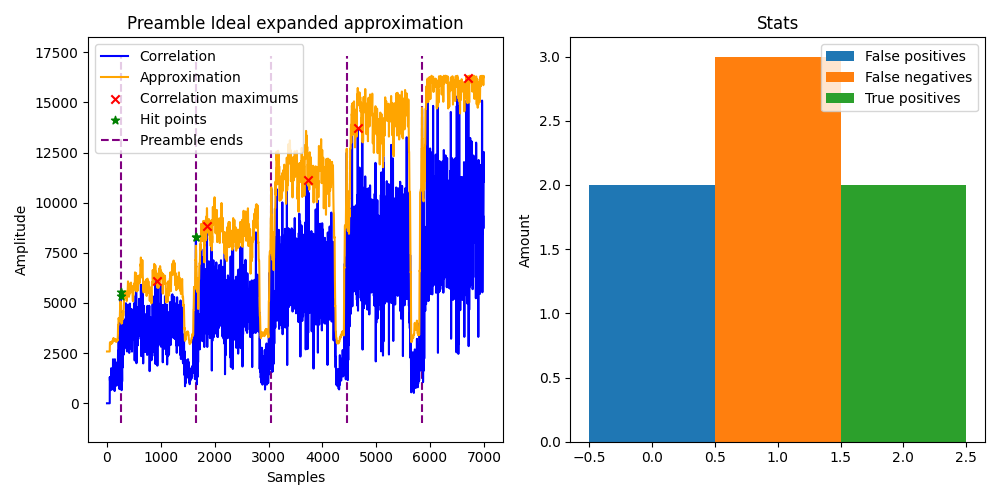

In [27]:
#Approximations
approx_data = np.load('generators/generated/python_approximations.npz')
loaded_poly_coeffs = approx_data['all_poly_coeffs'] #[preambule, approx, coefs]
approximation_type = Approximation.Mean.value

for preambule_i in range(len(preambule_list)):
    preamble = preambule_list[preambule_i]
    curr_preamble_corr = preamble.get_correlation(full_multiple_signal_digitized, Correlation.Basic)
    curr_energy = get_signal_energy(full_multiple_signal_digitized, len(preamble.get_coefficients()))
    curr_approx = generate_approx(curr_energy, loaded_poly_coeffs[preambule_i, approximation_type, :])
    corr_max_points = np.zeros((2, signal_amount))
    preamble_end_points = np.zeros((2, signal_amount))

    hit_points = np.array([[index, corr_value] for index, corr_value in enumerate(curr_preamble_corr) if corr_value > curr_approx[index] ]).T

    for i in range(signal_amount):
        corr_max_points[0, i] = np.argmax(curr_preamble_corr[i*one_signal_length : i*one_signal_length + one_signal_length]) + i * one_signal_length
        corr_max_points[1, i] = curr_preamble_corr[int(corr_max_points[0, i])]
        preamble_end_points[0, i] = multiple_signal_gaps + preamble.get_expected_maximum() + i * one_signal_length
        preamble_end_points[1, i] = curr_preamble_corr[int(preamble_end_points[0, i])]

    false_positives = []
    false_negatives = []
    true_positives = []
    # Populate false positives
    for j in range(len(hit_points[0, :])):
        if hit_points[0, j] not in preamble_end_points[0, :]:
            false_positives.append(1)
    # Populate false negatives and true positives
    for j in range(len(preamble_end_points[0, :])):
        if preamble_end_points[0, j] not in hit_points[0, :]:
            false_negatives.append(1)
        else:
            true_positives.append(1)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.plot(curr_preamble_corr, color="blue", label="Correlation", zorder=1)
    plt.plot(curr_approx, color="orange", label="Approximation", zorder=1)
    plt.scatter(corr_max_points[0, :], corr_max_points[1, :], color='red', marker = 'x', label="Correlation maximums", zorder=3)
    plt.scatter(hit_points[0, :], hit_points[1, :], color='green', marker = '*', label="Hit points", zorder=2)
    plt.vlines(preamble_end_points[0, :], ymin = min([min(curr_approx), min(curr_preamble_corr)]) - 1000,
               ymax = max([max(curr_approx), max(curr_preamble_corr)]) + 1000, linestyle='dashed', color='purple',
               label = "Preamble ends", zorder=0)
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.title("Preamble " + preambule_list[preambule_i].get_name() + " approximation")
    plt.legend()
    plt.subplot(122)

    bar_width = 1
    bars = [
        (false_positives, "False positives"),
        (false_negatives, "False negatives"),
        (true_positives, "True positives")

    ]
    bar_positions = np.arange(signal_amount)

    for j in range(len(bars)):
        bar_array, bar_name = bars[j]
        plt.bar(j,
                len(bar_array),
                width=bar_width,
                label=bar_name)

    # plt.xlabel('Signal Index')
    plt.ylabel('Amount')
    plt.title('Stats')
    plt.legend()

    plt.tight_layout()
    plt.show()